# **Redes Neuronales Artificiales**: Trabajo Práctico 1

#### Integrantes:

- Maximiliano Dacko, LU  284/21
- María Marino, LU 450/21
- Giovanni Franco Gabriel Marraffini, LU 292/21

## Clase `MLP`: Multi Level Perceptron

En primer lugar, se crea una clase para facilitar las acciones más utilizadas por la red neuronal. Esta consta de un constructor donde se definen la cantidad de neuronas de cada capa y la función de activación. Asimismo se crean las matrices pseudoaleatorias con una distribución normal.

Además, se utilizan como métodos públicos una función de activación de la red, una función de corrección de los pesos que utiliza el algortimo de *backpropagation* del error y una función para obtener los valores de salida dados nuevos datos de entrada.

Se decidió utilizar la misma función de activación para todas las capas. 

In [ ]:
import numpy as np

def sigmoid(x):
  return 1 / (1 + np.exp(-x))

class MLP:
    def __init__(self, sizes: list[int], batchSize: int, f: str = 'tanh'):
        self.S = sizes
        self.L = len(self.S)
        self.N = batchSize
        self.Y = [np.empty(shape=(self.N, self.S[i - 1] + 1)) for i in range(self.L)]
        self.W = [None] + [np.random.normal(0, 0.5, (self.S[i - 1] + 1, self.S[i])) for i in range(1, self.L)]
        self._f = f

    
    def _add_bias(self, V):
        bias = np.ones((len(V),1))
        return np.hstack([V, bias])

    def _sub_bias(self, V):
        return V[:, :-1]
    
    @property
    def f(self):
        return self._f

    @f.setter
    def f(self, fun):
        if fun != 'tanh' and fun != 'sigmoid': 
            raise Exception('Activation function should be  \'tanh\' or \'sigmoid\'')
    
    def activation(self, Xh):
        self.Y = [np.empty(shape=(self.N, self.S[i - 1] + 1)) for i in range(self.L)]
        Y_b = Xh
        for k in range(1, self.L):
            self.Y[k - 1] = self._add_bias(Y_b)
            if self.f == 'sigmoid':
                Y_b = sigmoid(self.Y[k - 1] @ self.W[k])
            else:
                Y_b = np.tanh(self.Y[k - 1] @ self.W[k])
        self.Y[self.L - 1] = Y_b
        return self.Y
    
    def correction(self, Yh, Zh):
        D = [np.empty(shape=(self.N, self.S[i - 1] + 1)) for i in range(self.L)]
        deltaW = [None] + [np.empty(shape=(self.S[i - 1] + 1, self.S[i])) for i in range(1, self.L)]
        E = Zh - Yh[self.L - 1]
        if self.f == 'sigmoid':
            dY = Yh[self.L - 1] * (1 - Yh[self.L - 1]) # Derivative of sigmoid
        else:
            dY = 1 - np.square(Yh[self.L - 1]) # Derivative of tanh
        D[self.L - 1] = E * dY
        for k in reversed(range(1, self.L)):
            deltaW[k] = Yh[k - 1].T @ D[k]
            E = D[k] @ self.W[k].T
            if self.f == 'sigmoid':
                dY = Yh[k - 1] * (1 - Yh[k - 1]) # Derivative of sigmoid
            else:
                dY = 1 - np.square(Yh[k - 1]) # Derivative of tanh
            D[k - 1] = self._sub_bias(E * dY)
        return deltaW

    def predict(self, x):
      return self.activation(x)[-1]

# **Ejercicio 1**

Se subieron los datos a un repositorio público para facilitar su importación.

Por el enunciado, sabemos que el conjunto de datos consta de las siguientes columnas:
1. *Diagnóstico, dónde 1 = maligno y 0 = benigno*. (**Nuestra variable objetivo**).
2. *Radio: media de la distancia desde el centro a los puntos deperímetro*
3. *Textura: desviación estándar de los valores en escala de gris*
4. *Perímetro*
5. *Área*
6. *Suavidad: variaciones locales en la longitud del radio*
7. *Compacidad: perímetro^2 / área - 1*
8. *Concavidad: severidad de las porciones cóncavas del contorno*
9. *Puntos cóncavos: proporción de porciones cóncavas del contorno*
10. *Simetría*
11. *Dimensión fractal*

In [ ]:
data = np.loadtxt('https://raw.githubusercontent.com/marinomaria/UBA-redes_neuronales/main/dataset/tp1-ej1.txt', delimiter = ',')

datasetSize = data.shape[0]

inputSize = 10
outputSize = 1

Se decide separar el 10% de los datos para luego evaluar con estos al final del entrenamiento y obtener un estimado del error real que podría llegar a cometer el modelo.

In [ ]:
np.random.shuffle(data)

evalSetSize = int(datasetSize * 0.1)
trainSet = data[: - evalSetSize, :]
evalSet = data[- evalSetSize:, :]

trainSet.shape, evalSet.shape

((369, 11), (41, 11))

### Estandarización

Para cada variable miramos su rango y promedio, y luego procedemos a estandarizar todo el dataset de entrenamiento **sin** la variable objetivo:

In [ ]:
for j in range(trainSet.shape[1]):
  print(f'Columna {j + 1}: \n Rango: {trainSet[:, j].min()} - {trainSet[:, j].max()} \n Promedio: {trainSet[:, j].mean()}')

Columna 1: 
 Rango: 0.0 - 1.0 
 Promedio: 0.4878048780487805
Columna 2: 
 Rango: 6.981 - 28.11 
 Promedio: 18.601371273712733
Columna 3: 
 Rango: 10.034 - 33.44 
 Promedio: 21.19330081300813
Columna 4: 
 Rango: 43.79 - 188.5 
 Promedio: 113.41271544715447
Columna 5: 
 Rango: 143.5 - 2501.0 
 Promedio: 850.2510623306233
Columna 6: 
 Rango: 0.053 - 4.099 
 Promedio: 1.788737127371274
Columna 7: 
 Rango: 0.387 - 3.345 
 Promedio: 1.885661246612466
Columna 8: 
 Rango: 0.427 - 7.283 
 Promedio: 3.6408428184281845
Columna 9: 
 Rango: 0.201 - 9.013 
 Promedio: 4.536311653116531
Columna 10: 
 Rango: 0.106 - 1.304 
 Promedio: 0.7225853658536586
Columna 11: 
 Rango: 0.05 - 2.974 
 Promedio: 1.5473387533875338


In [ ]:
z = trainSet[:, 0].reshape(trainSet.shape[0], 1)
x = trainSet[:, 1:trainSet.shape[1]]

z.shape, x.shape

((369, 1), (369, 10))

La estandarización utilizada es:

$z = \dfrac{x_{ij} - \mu_{j}}{\sigma_{j}}$

donde $x_{ij}$ es el valor original para la instancia $i$ en su variable $j$, $\mu_j$ y $\sigma_j$ son respectivamente la media y la desviación estándar de la variable $j$.

In [ ]:
x = (x - x.mean(0)) / x.std(0)

### Entrenamiento

Definimos el *batch size* (tamaño del lote) como un 10% del total de nuestro dataset. Teniendo en cuenta que ya quitamos un 10% para validación, nos quedan 9 lotes para entrenamiento.

Asimismo inicializamos una instancia de la clase `MLP`, definiendo aquí parte de su arquitectura. En este caso, nuestra red neuronal tendrá una única capa oculta cuyo tamaño será el doble del tamaño de entrada, y todas las capas utilizarán la función sigmoide como función de activación.

In [ ]:
bSize = int(datasetSize * 0.1)
M = MLP([inputSize, inputSize * 2, outputSize], bSize, 'sigmoid')

Entrenamos el modelo de a lotes. Elegimos entrenar por 40000 épocas para cumplir con lo pedido en el enunciado y que el modelo no tarde más de un minuto en entrenarse.

Cada ciclo del `while loop` exterior representa una época (*epoch*) y en él permutamos el orden de los datos para intentar evitar estancarnos en un mínimo local de nuestra función de error.

En cada iteración del `for loop` ingresamos un lote al modelo, activando la red y luego corrigiendo sus pesos con los métodos ya mencionados de la clase `MLP`.

Para calcular el error, sumamos el cuadrado de la diferencia entre el valor esperado (variable objetivo) y el valor predicho por el modelo, y luego dividimos por la cantidad de términos de la suma (error cuadrático medio).

Por último, imprimimos para algunas épocas el error estimado para poder observar su evolución.

In [ ]:
minError = 0.0001
maxEpoch = 40000
e = 1.0
eta = 0.001
epoch = 0
p = x.shape[0]

while e > minError and epoch < maxEpoch:
    stochastic = np.random.permutation(p)
    e = 0.0
    for i in range(0, p, bSize):
        batch = stochastic[i : i + bSize]
        xi = x[batch].reshape(bSize, 10)
        zi = z[batch].reshape(bSize, 1)
        yi = M.activation(xi)
        e += np.sum(np.square(zi - yi[-1]))
        dW = M.correction(yi, zi)
        for j in range(1, M.L):   
          M.W[j] += eta * dW[j]
    e /= p
    if (epoch % 10000 == 0 or epoch == maxEpoch - 1):
      print(f'Epoch {epoch}, error: {e}')
    epoch += 1 

Epoch 0, error: 0.3196186232210721
Epoch 10000, error: 0.03849632065520656
Epoch 20000, error: 0.013449500631073806
Epoch 30000, error: 0.008579452637621263
Epoch 39999, error: 0.006541638692360828


### Validación

Para validar el desempeño del modelo lo utilizamos para predecir el resultado del 10% del dataset que **no fue utilizado en su entrenamiento**.

Primero estandarizamos este dataset de validación como hicimos con los datos de entrenamiento, y luego comparamos los resultados obtenidos con los esperados.

In [ ]:
zEval = evalSet[:, 0:1].reshape(evalSet.shape[0], 1)
xEval = evalSet[:, 1:11]
xEval = (xEval - xEval.mean(0)) / xEval.std(0)

pred = np.zeros_like(zEval)

for i in range(len(evalSet)):
  pred[i] = M.predict(xEval[i].reshape(1, 10))

print(f'El modelo acertó en {np.sum(zEval == np.round(pred))} de {len(evalSet)} instancias ({100 * np.round(np.sum(zEval == np.round(pred)) / len(evalSet), 2)} %).\n\n')

for i in range(len(zEval)):
  print(f'Esperado: {zEval[i]}  Predicho: {pred[i]}   Redondeado: {np.round(pred[i])}')

El modelo acertó en 33 de 41 instancias (80.0 %).


Esperado: [0.]  Predicho: [0.00345947]   Redondeado: [0.]
Esperado: [1.]  Predicho: [0.99742525]   Redondeado: [1.]
Esperado: [1.]  Predicho: [0.90111181]   Redondeado: [1.]
Esperado: [1.]  Predicho: [0.99930487]   Redondeado: [1.]
Esperado: [0.]  Predicho: [0.60292348]   Redondeado: [1.]
Esperado: [0.]  Predicho: [0.08984131]   Redondeado: [0.]
Esperado: [1.]  Predicho: [0.49259027]   Redondeado: [0.]
Esperado: [0.]  Predicho: [0.2505731]   Redondeado: [0.]
Esperado: [1.]  Predicho: [0.96465163]   Redondeado: [1.]
Esperado: [1.]  Predicho: [0.97147201]   Redondeado: [1.]
Esperado: [1.]  Predicho: [0.9192532]   Redondeado: [1.]
Esperado: [1.]  Predicho: [0.98344597]   Redondeado: [1.]
Esperado: [1.]  Predicho: [0.96642993]   Redondeado: [1.]
Esperado: [1.]  Predicho: [0.99840584]   Redondeado: [1.]
Esperado: [0.]  Predicho: [0.5004319]   Redondeado: [1.]
Esperado: [0.]  Predicho: [0.5106831]   Redondeado: [1.]
Esperado: [0.]  Predicho

#### Validación cruzada con *K-folds*

Por último, para tener un mayor entendimiento de la performance del modelo en el "caso real" utilizamos el método *K-folds*.

La siguiente celda de código demora más en correr ya que entrena múltiples modelos con la misma arquitectura que el original pero variando los conjuntos de datos de entrenamiento y validación.

In [ ]:
s = np.random.permutation(datasetSize)

pred = np.empty(shape=(datasetSize, outputSize))

print(f'Cantidad de folds: {int(datasetSize / bSize)}. Tamaño de cada fold: {bSize} instancias.')

for i in range(0, datasetSize, bSize):
    fold = s[i : i + 82]
    evalSet = data[fold]
    trainSet = np.delete(data, fold, 0)

    x = trainSet[:, 1:11]
    z = trainSet[:, 0]
    
    x = (x - x.mean(0)) / x.std(0)

    M = MLP([inputSize, inputSize * 2, outputSize], bSize, 'sigmoid')

    e = 1.0
    epoch = 0
    p = len(trainSet)

    while e > minError and epoch < maxEpoch:
        stochastic = np.random.permutation(p)
        e = 0.0
        for j in range(0, p, bSize):
            batch = stochastic[j : j + bSize]
            xj = x[batch].reshape(bSize, M.S[0])
            zj = z[batch].reshape(bSize, M.S[-1])
            y = M.activation(xj)
            e += np.sum(np.square(zj - y[-1]))
            dW = M.correction(y, zj)
            for k in range(1, M.L):
                M.W[k] += eta * dW[k]
        e /= (p / bSize)
        epoch += 1 

    xEval = evalSet[:, 1:11]
    zEval = evalSet[:, 0]

    xEval = (xEval - xEval.mean(0)) / xEval.std(0)

    pred[fold] = M.predict(xEval)
    print(f'Modelo entrenado sin el fold {int(i / bSize)}. Error en la última época: {e}')


Cantidad de folds: 10. Tamaño de cada fold: 41 instancias.
Modelo entrenado sin el fold 0. Error en la última época: 0.36800509811383275
Modelo entrenado sin el fold 1. Error en la última época: 0.1346939025501628
Modelo entrenado sin el fold 2. Error en la última época: 0.13720234639960358
Modelo entrenado sin el fold 3. Error en la última época: 0.25093974040198885
Modelo entrenado sin el fold 4. Error en la última época: 0.1825338687636233
Modelo entrenado sin el fold 5. Error en la última época: 0.15329515656697157
Modelo entrenado sin el fold 6. Error en la última época: 0.1904755478063563
Modelo entrenado sin el fold 7. Error en la última época: 0.18781691899783984
Modelo entrenado sin el fold 8. Error en la última época: 0.21331884453630232
Modelo entrenado sin el fold 9. Error en la última época: 0.19838848849628624


Los *K-folds* se organizan de forma tal que para cada instancia se obtiene un resultado con alguno de los $K$ modelos entrenados. Guardamos esos resultados en el arreglo `pred` y los comparamos con los valores esperados para construir las métricas de *Recall* y Precisión.

$\text{Recall} = \dfrac{\text{Verdaderos Positivos}}{\text{Verdaderos Positivos} + \text{Falsos Negativos}}$

$\text{Precisión} = \dfrac{\text{Verdaderos Positivos}}{\text{Verdaderos Positivos} + \text{Falsos Positivos}}$


In [ ]:
expected = data[:, 0].reshape(datasetSize, outputSize)

tp = fn = tn = fp = 0

for i in range(len(pred)):
    if expected[i] == 1:
        if np.round(pred[i]) == 1:
            tp += 1
        else:
            fn += 1
    else:
        if np.round(pred[i]) == 1:
            fp += 1
        else:
            tn += 1

print('Recall:', tp / (tp + fn))
print('Precisión:', tp / (tp + fp))

print(f'\n\nSe cometieron {fp + fn} errores en {datasetSize} diagnósticos.')
print(f'Diagnosticamos como benignos a {fn} tumores malignos.')
print(f'Diagnosticamos como malignos a {fp} tumores benignos.')

Recall: 0.9076923076923077
Precisión: 0.8984771573604061


Se cometieron 38 errores en 410 diagnósticos.
Diagnosticamos como benignos a 18 tumores malignos.
Diagnosticamos como malignos a 20 tumores benignos.


En este caso la medida principal que queremos optimizar es el *recall*, ya que al tratarse de un problema de diagnóstico de cáncer de mama es preferible sobreestimar (dar un resultado positivo para tumores benignos) que subestimar, por el impacto que puede tener en las posibilidades de tratamiento y en la calidad de vida de un paciente la detección tardía de un tumor maligno.

Como alternativa para mejorar nuestro modelo podríamos agregar un *threshold* $\epsilon$, y sólo diagnosticar como benignos aquellos casos donde el modelo devuelva resultados menores a $0,5 + \epsilon$.

# **Ejercicio 2**

Para resolver este ejericio se utiliza la misma clase que en el ejericio anterior.

Al igual que antes se subieron los datos a un repositorio público para facilitar su lectura.

Sabemos por la consigna de este ejercicio que las columnas del dataset representan:

1. Compacidad Relativa
2. Área de la Superficie Total
3. Área de las Paredes
4. Área del Techo
5. Altura Total
6. Orientación
7. Área de Reflejo Total 
8. Distribución del Área de Reflejo
9. Carga de Calefacción
10. Carga de Refrigeración

Las últimas dos columnas serán las variables objetivo en este ejercicio.

In [ ]:
data = np.loadtxt('https://raw.githubusercontent.com/marinomaria/UBA-redes_neuronales/main/dataset/tp1-ej2.txt', delimiter = ',')

datasetSize = data.shape[0]
inputSize = 8
outputSize = 2

Separamos un 10% del dataset para validar posteriormente el desempeño del modelo en datos que no hayan sido utilizado en su entrenamiento.

In [ ]:
np.random.shuffle(data)

evalSetSize = int(datasetSize * 0.1)
trainSet = data[: - evalSetSize, :]
evalSet = data[- evalSetSize:, :]

trainSetSize = datasetSize - evalSetSize

trainSet.shape, evalSet.shape

((450, 10), (50, 10))

### Estandarización

In [ ]:
for j in range(inputSize + outputSize):
  print(f'Columna {j + 1}: \n Rango: {trainSet[:, j].min()} - {trainSet[:, j].max()} \n Promedio: {trainSet[:, j].mean()}')

Columna 1: 
 Rango: 0.62 - 0.98 
 Promedio: 0.7616444444444445
Columna 2: 
 Rango: 514.5 - 808.5 
 Promedio: 673.4233333333333
Columna 3: 
 Rango: 245.0 - 416.5 
 Promedio: 318.44555555555553
Columna 4: 
 Rango: 110.25 - 220.5 
 Promedio: 177.48888888888888
Columna 5: 
 Rango: 3.5 - 7.0 
 Promedio: 5.234444444444445
Columna 6: 
 Rango: 2.0 - 5.0 
 Promedio: 3.397777777777778
Columna 7: 
 Rango: 0.0 - 0.4 
 Promedio: 0.23077777777777778
Columna 8: 
 Rango: 0.0 - 5.0 
 Promedio: 2.7777777777777777
Columna 9: 
 Rango: 6.04 - 42.96 
 Promedio: 22.15886666666666
Columna 10: 
 Rango: 10.9 - 47.59 
 Promedio: 24.457


Observamos que los rangos de las columnas tienen distintos órdenes de magnitud. 

Estandarizamos utilizando una fórmula similar a la que empleamos en el Ejercicio 1, sólo que 
- Ahora dividiremos por la desviación estándar de **todo el conjunto de datos de entreanmiento**, no sólo de la variable $j$
- También estandarizaremos las variables objetivo.

$z = \dfrac{x_{ij} - \mu_{j}}{\sigma}$

donde $x_{ij}$ es el valor original para la instancia $i$ en su variable $j$, $\mu_j$ es la media de la variable $j$ y $\sigma$ es la desviación estándar del conjunto de datos de entrenamiento.

In [ ]:
trainSet = (trainSet - trainSet.mean(0)) / trainSet.std()

### Entrenamiento

Separamos en variables de entrada y variables objetivo.

In [ ]:
z = trainSet[:, inputSize:].reshape(trainSet.shape[0], 2)
x = trainSet[:, 0:inputSize]

x.shape, z.shape

((450, 8), (450, 2))

Definimos el *batch size* (tamaño del lote) como un 10% del conjunto total de datos. Teniendo en cuenta que ya quitamos un 10% para validación, nos quedan 9 lotes para entrenamiento.


Asimismo inicializamos una instancia de la clase `MLP`, definiendo aquí parte de su arquitectura. En este caso, nuestra red neuronal posee una capa oculta, cuyo tamaño será el doble del tamaño de entrada. Todas las capas utilizarán la función tangente hiperbólica como función de activación.

In [ ]:
bSize = int(datasetSize * 0.1)
M = MLP([inputSize, inputSize * 2, outputSize], bSize, 'tanh')

Entrenamos el modelo de a lotes. Aquí también elegimos entrenar por 40000 épocas para cumplir con la cota temporal del enunciado (un minuto).

Cada ciclo del `while loop` exterior representa una época (*epoch*) y en él permutamos el orden de los datos para intentar evitar estancarnos en un mínimo local de nuestra función de error.

En cada iteración del `for loop` ingresamos un lote al modelo, activando la red y luego corrigiendo sus pesos con los métodos ya mencionados de la clase `MLP`.

Para calcular el error, sumamos el cuadrado de la diferencia entre el valor esperado (variable objetivo) y el valor predicho por el modelo, y luego dividimos por la cantidad de términos de la suma (error cuadrático medio).

Por último, imprimimos para algunas épocas el error estimado para poder observar su evolución.

In [ ]:
minError = 0.000001
maxEpoch = 40000
e = 1.0
epoch = 0
eta = 0.001
p = len(trainSet)

while e > minError and epoch < maxEpoch:
    stochastic = np.random.permutation(p)
    e = 0.0
    for i in range(0, p, bSize):
        batch = stochastic[i : i + bSize]
        xi = x[batch].reshape(bSize, M.S[0])
        zi = z[batch].reshape(bSize, M.S[-1])
        y = M.activation(xi)
        e += np.sum(np.square(zi - y[-1]))
        dW = M.correction(y, zi)
        for i in range(1, M.L):
          M.W[i] += eta * dW[i]
    e /= p
    if epoch % 10000 == 0 or epoch == maxEpoch - 1:
      print(f'Epoch {epoch}, error: {e}')
    epoch += 1 

Epoch 0, error: 0.5581709574724008
Epoch 10000, error: 0.0006484536721248918
Epoch 20000, error: 0.0006084436133713308
Epoch 30000, error: 0.0005776930113166594
Epoch 39999, error: 0.0005624972118241038


### Validación

Para validar el desempeño del modelo lo utilizamos para predecir el resultado del 10% del dataset que **no fue utilizado en su entrenamiento**.

Primero estandarizamos este dataset de validación como hicimos con los datos de entrenamiento, y luego comparamos los resultados obtenidos con los esperados.

In [ ]:
evalSet = data[- evalSetSize:, :]
evalSet = (evalSet - evalSet.mean(0)) / evalSet.std()

zEval = evalSet[:, inputSize:].reshape(evalSetSize, 2)
xEval = evalSet[:, 0:inputSize]

pred = np.zeros_like(zEval)

for i in range(len(evalSet)):
  pred[i] = M.predict(xEval[i].reshape(1, 8))
  print(f'Esperado: {zEval[i]}  Predicho: {pred[i]}   Diferencia: {np.linalg.norm(zEval[i] - pred[i], 1)}')

print('\n\nError cuadrático medio por variable:', np.mean(np.square(zEval - pred), axis = 0))
print('Error absoluto medio:', np.mean(np.linalg.norm(zEval - pred, 1, axis=1)))

Esperado: [-0.0356849  -0.04237446]  Predicho: [-0.03589265 -0.0391285 ]   Diferencia: 0.0034537121031655016
Esperado: [-0.0501041  -0.05093143]  Predicho: [-0.0397359  -0.03701973]   Diferencia: 0.02427988712121181
Esperado: [-0.05067141 -0.05244426]  Predicho: [-0.04595925 -0.04136567]   Diferencia: 0.0157907556092935
Esperado: [-0.03317927 -0.02530781]  Predicho: [-0.03556766 -0.03616525]   Diferencia: 0.01324583180345762
Esperado: [-0.04528194 -0.04904038]  Predicho: [-0.03422101 -0.03784294]   Diferencia: 0.022258372104101427
Esperado: [-0.03729229 -0.03641768]  Predicho: [-0.04684053 -0.04504546]   Diferencia: 0.018176020349276498
Esperado: [-0.02396044 -0.01954013]  Predicho: [-0.04083559 -0.0401978 ]   Diferencia: 0.03753281181394267
Esperado: [0.03234532 0.02395383]  Predicho: [0.05113936 0.04598008]   Diferencia: 0.04082028896084869
Esperado: [0.01144931 0.00868366]  Predicho: [0.01780358 0.02177446]   Diferencia: 0.019445064345141216
Esperado: [0.03504006 0.02589214]  Predic

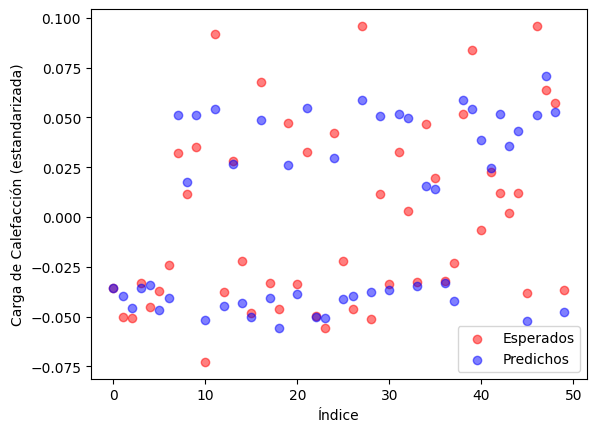

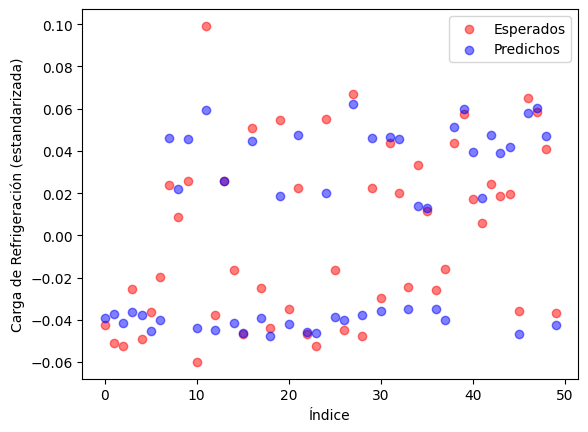

In [ ]:
import matplotlib.pyplot as plt


plt.scatter(range(evalSetSize), zEval[:, 0], c ='red', alpha=0.5)
plt.scatter(range(evalSetSize), pred[:, 0], c ='blue', alpha=0.5)
plt.ylabel('Carga de Calefacción (estandarizada)')
plt.xlabel('Índice')
plt.legend(['Esperados', 'Predichos'])
plt.show()

plt.scatter(range(evalSetSize), zEval[:, 1], c ='red', alpha=0.5)
plt.scatter(range(evalSetSize), pred[:, 1], c ='blue', alpha=0.5)
plt.ylabel('Carga de Refrigeración (estandarizada)')
plt.xlabel('Índice')
plt.legend(['Esperados', 'Predichos'])
plt.show()

El error cuadrático medio para el conjunto de datos de evaluación es cercano al obtenido en la última época de entrenamiento del modelo. Con esto entendemos que no estamos sobre-ajustando el modelo a los datos de entrenamiento, sino que el ajuste es adecuado.

Para analizar la magnitud del error preferimos utilizar el error absoluto medio, que se encuentra en la misma escala que las variables objetivo estandarizadas. El rango de las mismas es [-1, 1]. La media del error absoluto nos indica que tomando el modulo del "vector error", es decir, la diferencia entre los valores reales  y los predichos para ambas variables, nos daría en promedio 0.03 aproximadamente. Obviamente esto toma en cuenta ambas variables, pero si queremos analizar cada una por separado, podemos tomar la raiz del error cuadratico medio calculado para cada variable objetivo. En este caso para la primera variable nos quedaría una diferencia estimada en promedio de 0,02 y para la segunda variable, una diferencia estimada de 0.018 aunque obviamente estos valores pueden variar ligeramente en diferentes corridas del algoritmo.